# Lane-Keeping Assistant: Deep Learning Model Training (PyTorch)

# 1. Introduction
This Kaggle Notebook details the training of a Convolutional Neural Network (CNN) for a simulated autonomous vehicle's lane-keeping assistant using PyTorch. The model predicts steering angles based on front-facing camera images. The goal is to enable autonomous navigation within a simulated environment.

## 1.1.  Dataset
The model is trained on a custom synthetic dataset comprising **34,379 grayscale images** from both straight and curved road segments, along with corresponding steering angle labels. The dataset is diverse, incorporating varying car speeds, lateral offsets, starting angles, and camera perspectives.
**[Link to Kaggle Dataset Here](https://www.kaggle.com/datasets/afsanehm/simulated-driving-data)**

## 1.2. Model Architecture
The model uses a CNN architecture inspired by **[NVIDIA's End-to-End Deep Learning for Self-Driving Cars](https://arxiv.org/pdf/1604.07316)**, adapted for grayscale input and specific output requirements within a PyTorch framework.

## 1.3. Workflow
1.  **Data Loading & Preprocessing:** Loads labels, prepares image paths, and defines image preprocessing (resizing, cropping, normalisation).
2.  **PyTorch Dataset & DataLoader:** Implements custom `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` for efficient batch-wise data loading and augmentation.
3.  **Model Definition:** Defines the CNN architecture using `torch.nn.Module`.
4.  **Training Loop:** Implements a manual training and validation loop.
5.  **Evaluation:** Assess model performance on unseen test data.
6.  **Model Saving:** Saves the trained model in a PyTorch-compatible format for deployment.

# 2. Setup & Data Loading

This section covers the initial setup of the Kaggle environment, importing necessary libraries, configuring the GPU, and loading the raw dataset labels. 

**Ensure that GPU acceleration is enabled for this notebook under "Accelerator" in the notebook settings to leverage faster training.**

## 2.1. Import Libraries

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms # Useful for image transformations

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

## 2.2 Environment Setup & Data Paths
Here, we verify GPU availability and define the paths to the dataset files within the Kaggle environment.

In [2]:
# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

# Data Path Configuration
#print(os.listdir("/kaggle/input/"))
dataset_slug = 'simulated-driving-data'
dataset_path = os.path.join('/kaggle/input/', dataset_slug)

images_dir = os.path.join(dataset_path, 'all_images')
labels_file = os.path.join(dataset_path, 'combined_labels.csv')

# Verify paths and existence
print(f"Dataset path: {dataset_path}")
print(f"Images directory: {images_dir}")
print(f"Labels file: {labels_file}")

if not os.path.exists(images_dir):
    print(f"Error: Images directory not found at {images_dir}")
if not os.path.exists(labels_file):
    print(f"Error: Labels file not found at {labels_file}")

Using device: cuda
CUDA device name: Tesla T4
CUDA memory allocated: 0.00 GB
Dataset path: /kaggle/input/simulated-driving-data
Images directory: /kaggle/input/simulated-driving-data/all_images
Labels file: /kaggle/input/simulated-driving-data/combined_labels.csv


## 2.3. Load Labels & Sample Visualisation
This section reads the `combined_labels.csv` file into a Pandas DataFrame, constructs full image paths, and displays a sample image with its corresponding steering angle.


Total samples: 34379

First 2 image paths:
/kaggle/input/simulated-driving-data/all_images/image_000000.png
/kaggle/input/simulated-driving-data/all_images/image_000001.png


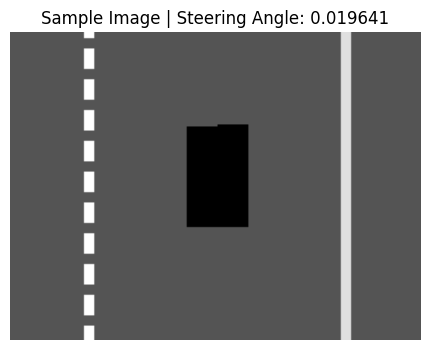

In [3]:
# Load the combined labels file
df_labels = pd.read_csv(labels_file)
print(f"Total samples: {len(df_labels)}")
#print("DataFrame head:")
#pd.set_option('display.float_format', '{:.6f}'.format)
#print(df_labels.head())

# Add full image path to the DataFrame
df_labels['image_path'] = df_labels['image_filename'].apply(lambda x: os.path.join(images_dir, x))

# Verify a few paths and display a sample image
print("\nFirst 2 image paths:")
for i in range(0, 2):
    print(df_labels['image_path'].iloc[i])

# Display a sample image
sample_img_path = df_labels['image_path'].iloc[40]
sample_steering = df_labels['steering_angle'].iloc[40]

plt.figure(figsize=(8, 4))
sample_img = mpimg.imread(sample_img_path)
plt.imshow(sample_img, cmap='gray') # Assuming grayscale images
plt.title(f"Sample Image | Steering Angle: {sample_steering:.6f}")
plt.axis('off')
plt.show()

# 3. Data Preparation for PyTorch 

This section focuses on preparing the dataset for training with PyTorch, including splitting the data and creating custom PyTorch `Dataset` and `DataLoader` classes.

## 3.1. Data Splitting
Here, we divide the dataset into training, validation, and test sets. This will ensure robust model evaluation and prevent overfitting.

In [4]:
# Split data into training, validation, and test sets
X = df_labels['image_path'].values
y = df_labels['steering_angle'].values

# 1. Split into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=SEED, shuffle=True
)

# 2. Split the training+validation set into distinct training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, 
    random_state=SEED, shuffle=True
) # 0.176 of 85% is ~15% of the total dataset for validation

print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Total samples: 34379
Training samples: 24078
Validation samples: 5144
Test samples: 5157


## 3.2. Image Preprocessing & Custom Dataset
This section defines the image preprocessing pipeline and implements a custom `LaneKeepingDataset` class to handle image loading and transformations efficiently. This class inherits from `torch.utils.data.Dataset`.

## 3.2.1. PyTorch DataLoaders
We instantiate `torch.utils.data.DataLoader` objects for the training, validation, and test sets. These DataLoaders manage batching, shuffling, and multi-threaded data loading for efficient training.


In [5]:
# Define target image dimensions for the model
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 66, 200, 1 # For grayscale
# PyTorch expects dimensions (C, H, W)

class LaneKeepingDataset(Dataset):
    def __init__(self, image_paths, steering_angles, transform=None):
        self.image_paths = image_paths
        self.steering_angles = steering_angles
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        steering_angle = self.steering_angles[idx]

        # 1. Load image (mpimg.imread loads as (H, W) for grayscale)
        img = mpimg.imread(img_path)

        # 2. Preprocessing Steps
        # Convert to float32 (PyTorch expects float Tensors)
        img = img.astype(np.float32)

        # Ensure 3D (H, W, C) for consistency, then transpose to (C, H, W) for PyTorch
        if img.ndim == 2:
            img = np.expand_dims(img, axis=-1) # Add channel dim (H, W, 1)

        # Apply transformations (cropping, resizing, normalisation)
        if self.transform:
            img = self.transform(img)

        # Steering angle to tensor
        steering_angle = torch.tensor(steering_angle, dtype=torch.float32)

        return img, steering_angle

# Image Transformations
# We use torchvision.transforms.Compose for chaining transformations
# Here, we'll assume resizing and normalisation.
image_transform = transforms.Compose([
    transforms.ToPILImage(), # Convert numpy array to PIL Image for torchvision transforms
    transforms.Grayscale(num_output_channels=IMG_CHANNELS), # grayscale
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)), # Resize to target dimensions
    transforms.ToTensor(), # Convert PIL Image to PyTorch Tensor (automatically normalises to [0,1])
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalise to [-1, 1] for grayscale
    # If we have RGB images, we will use mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
])

# Instantiate Datasets
train_dataset = LaneKeepingDataset(X_train, y_train, transform=image_transform)
val_dataset = LaneKeepingDataset(X_val, y_val, transform=image_transform)
test_dataset = LaneKeepingDataset(X_test, y_test, transform=image_transform)

# Instantiate DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, num_workers=2) # num_workers for parallel loading
val_loader = DataLoader(val_dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False, num_workers=2)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 377
Number of validation batches: 81
Number of test batches: 81


# 4. Model Architecture

This section defines the deep learning model architecture used for the lane-keeping task.

## 4.1. NVIDIA PilotNet Model Definition
We implements the Convolutional Neural Network (CNN) based on the NVIDIA PilotNet architecture using `torch.nn.Module`. This includes convolutional layers for feature extraction followed by fully connected layers for regression. This  architecture is proven to be effective for end-to-end self-driving and provides a good balance of feature extraction and parameter count for this type of regression task.

In [6]:
class NVIDIA_PilotNet(nn.Module):
    def __init__(self):
        super(NVIDIA_PilotNet, self).__init__()

        # Convolutional Layers
        # Input: (Batch_Size, C, H, W) -> (Batch_Size, 1, 66, 200) for grayscale
        self.conv_layers = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 24, kernel_size=5, stride=2), # Output: (24, 31, 98) assuming 66x200 input
            nn.ReLU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2), # Output: (36, 14, 47)
            nn.ReLU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2), # Output: (48, 5, 22)
            nn.ReLU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1), # Output: (64, 3, 20)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), # Output: (64, 1, 18)
            nn.ReLU()
        )

        # Flatten layer
        # Calculate the flattened size: 64 * 1 * 18 = 1152
        # A good way to calculate this dynamically  based on exact output dims from conv layers
        # self._to_linear = None # To store computed flattened size
        # self._compute_flat_size(torch.zeros(1, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH))

        # Fully Connected Layers
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 1 * 18, 100), 
            nn.ReLU(),
            nn.Dropout(0.5), # Dropout for regularisation
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 1) # Output for steering angle (regression)
        )


    def forward(self, x):
        x = self.conv_layers(x)
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1) # Flatten except for batch dimension
        x = self.fc_layers(x)
        return x

# Instantiate the model and move to device (GPU if available)
model = NVIDIA_PilotNet().to(device)
print(model)

NVIDIA_PilotNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=1152, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=50, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=1, bias=True)
  )
)


## 4.2. Explanation of the NVIDIA_PilotNet Code
This class defines a Convolutional Neural Network (CNN) architecture inspired by NVIDIA's PilotNet, implemented in PyTorch.

1. `class NVIDIA_PilotNet(nn.Module)`:
    * This line defines a Python class named NVIDIA_PilotNet.
    * It inherits from `nn.Module`, which is the base class for all neural network modules in PyTorch. Any custom model or layer we create in PyTorch must inherit from `nn.Module`.

2. `def __init__(self)`:
    * This is the constructor for our class. It's called when we create an instance of the `NVIDIA_PilotNet` model (e.g., `model = NVIDIA_PilotNet()`).
    * `super(NVIDIA_PilotNet, self).__init__()`: This line calls the constructor of the parent class (`nn.Module`). This is a standard Python practice and necessary for PyTorch modules to be set up correctly.

3. `self.conv_layers = nn.Sequential(...)`
    * This defines the convolutional backbone of the network. `nn.Sequential` is a convenient container that allows us to stack layers sequentially. The input will pass through each layer in the order they are defined.
    * **Input Assumption**: The comment `Input: (Batch_Size, C, H, W) -> (Batch_Size, 1, 66, 200)` for grayscale clarifies that the model expects input images in PyTorch's channel-first format (Channels, Height, Width), with 1 channel for grayscale, and a size of 66x200 pixels.

4. **Convolutional Layers (`nn.Conv2d`)**
    * These layers are the core of feature extraction in image processing. Each `nn.Conv2d` layer takes several parameters:
        * `in_channels`: Number of input channels to the layer (e.g., 1 for grayscale input, or the number of output channels from the previous layer).
        * `out_channels`: Number of feature maps (or filters) produced by this layer. This becomes the `in_channels` for the next `Conv2d` layer.
        * `kernel_size`: The dimensions of the convolution filter (e.g., `(5, 5)` means a 5x5 filter).
        * `stride`: How many pixels the filter moves at each step. A stride of 2 downsamples (reduces) the spatial dimensions (height and width). A stride of 1 means no downsampling.
        * `padding`: (implying default of 0). This determines how much zero-padding is added to the input boundaries.
    * `nn.ReLU()`: Rectified Linear Unit. This is an activation function applied after each convolutional layer. It introduces non-linearity, allowing the network to learn more complex patterns.

### How Dimensions Are Calculated

The output spatial dimensions (Height and Width) of a convolutional layer are calculated using the following formula:

$Output\_Dim = \lfloor \frac{Input\_Dim - Kernel\_Size + 2 \times Padding}{Stride} \rfloor + 1$

Assuming an input of `(1, 66, 200)`, the dimensions through our `conv_layers` are:

1. `nn.Conv2d(IMG_CHANNELS, 24, kernel_size=5, stride=2)`
    * `IMG_CHANNELS` is 1.
    * Input: `(1, 66, 200)`
    * Output Channels: 24
    * Height: $\lfloor \frac{66 - 5 + 2 \times 0}{2} \rfloor + 1$ = 31
    * Width: $\lfloor \frac{200 - 5 + 2 \times 0}{2} \rfloor + 1$ = 98

2. `nn.Conv2d(24, 36, kernel_size=5, stride=2)`
    * Input: `(24, 31, 98)`
    * Output Channels: 36
    * Height: 14
    * Width: 47

3. `nn.Conv2d(36, 48, kernel_size=5, stride=2)`
    * Input: `(36, 14, 47)`
    * Output Channels: 48
    * Height: 5
    * Width: 22

4. `nn.Conv2d(48, 64, kernel_size=3, stride=1)`
    * Input: `(48, 5, 22)`
    * Output Channels: 64
    * Height: 3
    * Width: 20

5. `nn.Conv2d(64, 64, kernel_size=3, stride=1)`
    * Input: `(64, 3, 20)`
    * Output Channels: 64
    * Height: 1
    * Width: 18

6. `x.view(x.size(0), -1)` (Flattening)
    * After the convolutional layers, the feature maps are still 3D (Channels, Height, Width). To feed them into fully connected (dense) layers, they must be flattened into a 1D vector.
    * `x.size(0)` gets the batch size.
    * `-1` tells PyTorch to automatically calculate the remaining dimension, which will be Channels * Height * Width.
    * Based on our calculation for the last conv layer's output `(64, 1, 18)`, the flattened size is `64 * 1 * 18 = 1152`.

7. `self.fc_layers = nn.Sequential(...)` (Fully Connected Layers)
    * These are standard feed-forward layers.
    * `nn.Linear(in_features, out_features)`: A fully connected layer.
        * `in_features`: The size of the input vector (from the previous layer or the flattened conv output).
        * `out_features`: The number of neurons in this layer.
    * `nn.ReLU()`: Again, introduces non-linearity.
    * `nn.Dropout(0.5)`: A regularisation technique. During training, it randomly sets 50% of the input features to zero for each update. This helps prevent overfitting by forcing the network to learn more robust features.
    * `nn.Linear(10, 1)`: The last layer has 1 output neuron because we are performing a regression task (predicting a single continuous value: the steering angle). No activation function is needed here for regression, as we want the raw output value.

8. `def forward(self, x)`:
    * This method defines the forward pass of the network. It specifies how data `x` flows through the layers we defined in `__init__`.
    * `x = self.conv_layers(x)`: Pass the input through all the convolutional layers.
    * `x = x.view(x.size(0), -1)`: Flatten the output of the convolutional layers, keeping the batch dimension.
    * `x = self.fc_layers(x)`: Pass the flattened output through the fully connected layers.
    * `return x`: Returns the final prediction.

### Why these specific layers and dimensions?

The choices of layers, kernel sizes, strides, and number of filters are largely inspired by the original NVIDIA PilotNet paper.

* **Progressive Downsampling (Strides)**: The initial layers use a stride of 2 (`(5,5)` kernel, stride 2) to rapidly reduce the spatial dimensions of the image. This helps capture broad features efficiently and reduces the computational load for subsequent layers.
* **Increasing Filters**: The number of `out_channels` (filters) increases in earlier convolutional layers (24, 36, 48) and then stabilises (64, 64). This allows the network to learn more complex and abstract features as it processes the input.
* **Smaller Kernels Later**: After aggressive downsampling, smaller kernel sizes (`(3,3)`) with a stride of 1 are used. This allows the network to extract finer-grained details without further reducing the spatial resolution too much.
* **Fully Connected Layers**: These layers are responsible for taking the high-level features extracted by the CNN and mapping them to the final steering angle prediction. The progressively smaller number of neurons (100, 50, 10, 1) helps condense the information.
* **Dropout**: Essential for preventing overfitting, especially in smaller datasets or when the model is complex.
*  The choice of filter counts (24, 36, 48, 64, 64) is a well-established and empirically validated design pattern originated from the PilotNet paper.

# 5. Model Training

This section covers the compilation and training process of the PyTorch model, including defining the loss function, optimizer, learning rate scheduler, and implementing the training loop.

## 5.1 Training Configuration
We set up the Mean Squared Error (MSE) loss function and the Adam optimizer.

* Mean Squared Error (MSE) calculates the average of the squares of the errors (or deviations) between the predicted values and the actual (true) values.
* Adam Optimizer: Adam (Adaptive Moment Estimation) is an optimisation algorithm that computes individual adaptive learning rates for different parameters based on estimates of first and second moments of the gradients. This makes it highly efficient and generally performs well across a wide range of deep learning problems, requiring minimal hyperparameter tuning.
* `ReduceLROnPlateau` is a popular PyTorch learning rate scheduler that reduces the learning rate when a monitored metric has stopped improving. `ReduceLROnPlateau` scheduler will:
    * Monitor the validation loss (`mode='min'`). If the validation loss does not decrease for 5 consecutive epochs (`patience=5`), the current learning rate of the Adam optimizer will be multiplied by 0.2 (`factor=0.2`), provided it does not go below 0.0000001 (`min_lr=0.0000001`). A message will be printed whenever this happens (`verbose=True`).

In [7]:
# Loss Function (Mean Squared Error: good choice for regression)
criterion = nn.MSELoss()

# Optimiser (Adam: gradient-based opimisation)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning Rate Scheduler (ReduceLROnPlateau is common for validation loss monitoring)
# It adjusts the learning rate of the optimizer 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, 
                              verbose = True, min_lr=0.0000001)

# Model Saving Path
best_model_path = '/kaggle/working/best_lane_keeping_model.pth'

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 5.2 Training Loop & Callbacks
We implement the core training loop, iterating through epochs and batches. It includes:
* Forward pass, loss calculation, and backpropagation.
* Validation phase to monitor performance on unseen data.
* Learning rate scheduling to adjust the learning rate during training.
* Model checkpointing to save the best-performing model based on validation loss.


In [8]:
num_epochs = 49 # 100
best_val_loss = float('inf')
train_losses = []
val_losses = []

print("Starting training")
for epoch in range(num_epochs):
    # Training Phase
    model.train() # Set model to training mode
    running_train_loss = 0.0
    for batch_idx, (images, steering_angles) in enumerate(train_loader):
        images = images.to(device) # Move images to GPU
        steering_angles = steering_angles.to(device).view(-1, 1) # Ensure angles are (batch_size, 1)

        optimizer.zero_grad() # Zero the parameter gradients

        outputs = model(images) # Forward pass
        loss = criterion(outputs, steering_angles) # Calculate loss

        loss.backward() # Backward pass
        optimizer.step() # Optimise

        running_train_loss += loss.item() * images.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)


    # --- ---- Validation Phase 
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for validation
        for images, steering_angles in val_loader:
            images = images.to(device)
            steering_angles = steering_angles.to(device).view(-1, 1)

            outputs = model(images)
            loss = criterion(outputs, steering_angles)
            running_val_loss += loss.item() * images.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # --- ---- Learning Rate Scheduler Step
    scheduler.step(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # --- ---- Model Checkpointing (Saving the best model) ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path) # Saves only the model's learned parameters
        print(f"--> Saved best model with Val Loss: {best_val_loss:.4f}")

    # Optional: Early Stopping (manual check, or use a callback library if preferred)
    # This basic example implements manual checkpointing/early stopping logic.
    # For a full implementation, you'd track patience for early stopping.
    # e.g., if epoch_val_loss doesn't improve for 'patience' epochs, break training.

print("Training complete!")

Starting training
Epoch [1/49], Train Loss: 19.6429, Val Loss: 22.6437
--> Saved best model with Val Loss: 22.6437
Epoch [2/49], Train Loss: 17.7004, Val Loss: 22.0436
--> Saved best model with Val Loss: 22.0436
Epoch [3/49], Train Loss: 16.2612, Val Loss: 17.7254
--> Saved best model with Val Loss: 17.7254
Epoch [4/49], Train Loss: 12.0533, Val Loss: 11.4467
--> Saved best model with Val Loss: 11.4467
Epoch [5/49], Train Loss: 7.2955, Val Loss: 7.4200
--> Saved best model with Val Loss: 7.4200
Epoch [6/49], Train Loss: 6.3597, Val Loss: 5.4523
--> Saved best model with Val Loss: 5.4523
Epoch [7/49], Train Loss: 6.3805, Val Loss: 4.7168
--> Saved best model with Val Loss: 4.7168
Epoch [8/49], Train Loss: 5.4593, Val Loss: 4.1599
--> Saved best model with Val Loss: 4.1599
Epoch [9/49], Train Loss: 5.7316, Val Loss: 4.4337
Epoch [12/49], Train Loss: 4.8166, Val Loss: 4.3597
Epoch [13/49], Train Loss: 4.3849, Val Loss: 4.4965
Epoch [14/49], Train Loss: 4.9017, Val Loss: 3.7719
--> Saved b

### 5.2.1. Explanation of Training Loop Details
* `images.size(0)`: Represents the number of images in the current batch.
* Why multiply loss.item() by images.size(0)?
    * The loss variable typically represents the average loss per sample within that specific batch. When we call `loss.item()`, we get this average loss as a standard Python number. By multiplying `loss.item() * images.size(0)`, we are converting the average batch loss back to the sum of losses for all samples in that batch. We then accumulate these summed batch losses in `running_train_loss`. This way, when we calculate the `epoch_train_loss` at the end of an epoch by dividing `running_train_loss` by the total number of samples (`len(train_loader.dataset)`), we get the true average loss over all individual samples in the entire training set for that epoch.
* `torch.no_grad()`: This is used to make the validation (and inference) code more memory-efficient and faster because gradient calculations are unnecessary when we're not updating the model's parameters.
    *  In the validation (or testing/inference) phase, we only evaluate the model's performance on unseen data. We do not performe backpropagation or update the model's weights. The purpose is to get a performance metric (like validation loss) on the current state of the model. 

# 6. Evaluation & Model Saving

This final section evaluates the trained model's performance on the test set and saves the best model for future use and deployment.

## 6.1 Plot Training History
We visualise the training and validation loss over epochs to assess model convergence and identify potential overfitting.

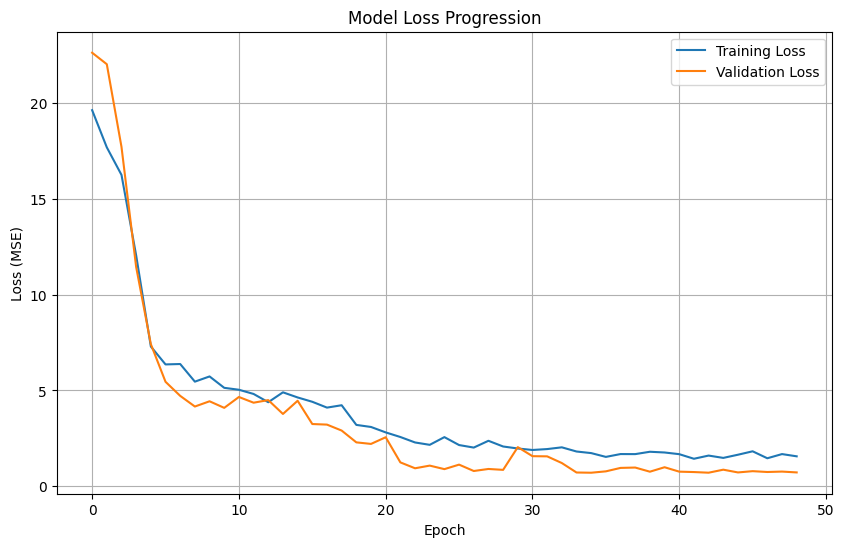

In [9]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss Progression')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


## 6.2 Evaluate on Test Set
Here, we load the best-performing model (saved during training) and evaluate its performance on the completely unseen test dataset.

In [10]:
# Load the best model's weights (saved during training)
try:
    best_model_loaded = NVIDIA_PilotNet().to(device) # Re-instantiate the model
    best_model_loaded.load_state_dict(torch.load(best_model_path)) # Load the saved state_dict
    best_model_loaded.eval() # Set to evaluation mode
    print(f"Loaded best model for evaluation from {best_model_path}")
except Exception as e:
    print(f"Could not load best model, evaluating the last trained model. Error: {e}")
    best_model_loaded = model # Fallback to the last trained model if loading checkpoint fails
    best_model_loaded.eval() # Ensure it's in eval mode

print("\nEvaluating model on the test set...")
running_test_loss = 0.0
with torch.no_grad():
    for images, steering_angles in test_loader:
        images = images.to(device)
        steering_angles = steering_angles.to(device).view(-1, 1)

        outputs = best_model_loaded(images)
        loss = criterion(outputs, steering_angles)
        running_test_loss += loss.item() * images.size(0)

test_loss = running_test_loss / len(test_loader.dataset)
print(f"Test Loss (MSE): {test_loss:.4f}")

# Optional: Calculate Mean Absolute Error (MAE) for better interpretability
# from sklearn.metrics import mean_absolute_error
# all_predictions = []
# all_true_angles = []
# with torch.no_grad():
#     for images, steering_angles in test_loader:
#         images = images.to(device)
#         outputs = best_model_loaded(images)
#         all_predictions.extend(outputs.cpu().numpy().flatten())
#         all_true_angles.extend(steering_angles.cpu().numpy().flatten())
#
# mae = mean_absolute_error(all_true_angles, all_predictions)
# print(f"Test Mean Absolute Error (MAE): {mae:.4f}")

Loaded best model for evaluation from /kaggle/working/best_lane_keeping_model.pth

Evaluating model on the test set...
Test Loss (MSE): 0.8591


## 6.3 Save Model for Deployment
Saves the trained model's `state_dict` (learned parameters) in a `.pth` file, making it ready for download.

The best model's state_dict is already saved to 'best_lane_keeping_model.pth' during training. This file contains only the learned parameters.

In [13]:
#  To save the entire model (architecture + parameters):
torch.save(best_model_loaded, '/kaggle/working/entire_lane_keeping_model.pth')
# This is generally less flexible for loading into different environments/versions,
# but can be simpler for a direct re-load in PyTorch.

print(f"Best model state_dict saved to: {best_model_path}")
print(f"Entire model (architecture + parameters) saved to: {'/kaggle/working/entire_lane_keeping_model.pth'}")

Best model state_dict saved to: /kaggle/working/best_lane_keeping_model.pth
Entire model (architecture + parameters) saved to: /kaggle/working/entire_lane_keeping_model.pth
